# Reducing Bias in Machine Learning Models:
### Modeling Part 2: Advanced Models (Base and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 4: Advanced Models (Base and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Random Forest](#ran)
    - 1.3: [xGBoost](#xgb)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our advanced models and then optimizing them for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 4: Advanced Modelling (Base and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score, auc
)
import xgboost as xgb
from joblib import dump
import json
import shap
from sklearn.model_selection import StratifiedKFold, cross_val_score

Loading the clean csv file

In [14]:
health_data = pd.read_csv('Data/clean_health_data_pt3.csv')

In [15]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [16]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lungexternl,pmh_lymphenlarg,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_conjunctivitis,cc_constipation,cc_cough,cc_cyst,cc_decreasedbloodsugar-symptomatic,cc_dehydration,cc_dentalpain,cc_depression,cc_detoxevaluation,cc_diarrhea,cc_dizziness,cc_drug/alcoholassessment,cc_drugproblem,cc_dyspnea,cc_

In [17]:
health_data.shape

(105627, 419)

In [18]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int64(419)
memory usage: 337.7 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [19]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [20]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(419)
memory usage: 42.2 MB


As we can see, the memory usage has decreased from 337.7 mb to 42.2mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Random Forest

To build on top of the prior base model of a decision tree, I will be doing random forest. Random Forest is an ensemble learning method that combines the predictions of multiple individual models (decision trees) to create a more robust and accurate model. Random Forests can effectively handle datasets with binary features. The random subset of features considered at each split helps in decorrelating trees and capturing diverse patterns.

In [21]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Accuracy: 0.9953373332859966

Cross-Validation Scores (5-fold - Test Set): [0.77425461 0.7895858  0.76946746 0.77278107 0.7756213 ]
Mean CV Accuracy (5-fold - Test Set): 0.7763420471188501
Test Accuracy: 0.7849095900785762

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81     11348
           1       0.79      0.72      0.76      9778

    accuracy                           0.78     21126
   macro avg       0.79      0.78      0.78     21126
weighted avg       0.79      0.78      0.78     21126


Confusion Matrix (Test):
 [[9493 1855]
 [2689 7089]]


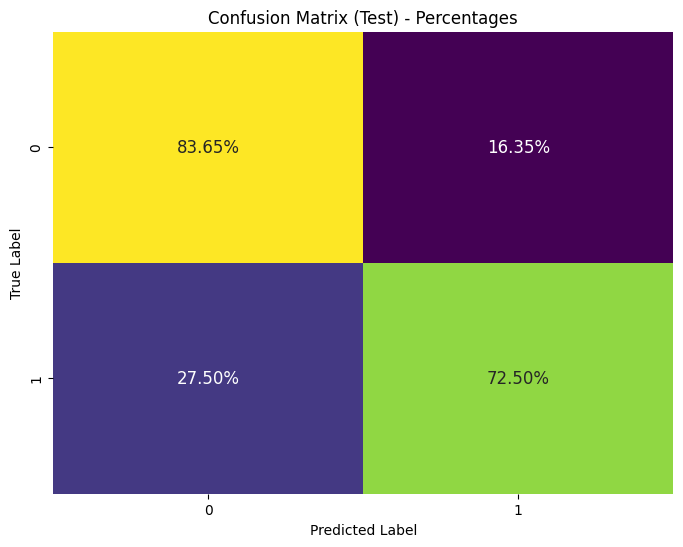

AUC-ROC Score: 0.8607521007609682


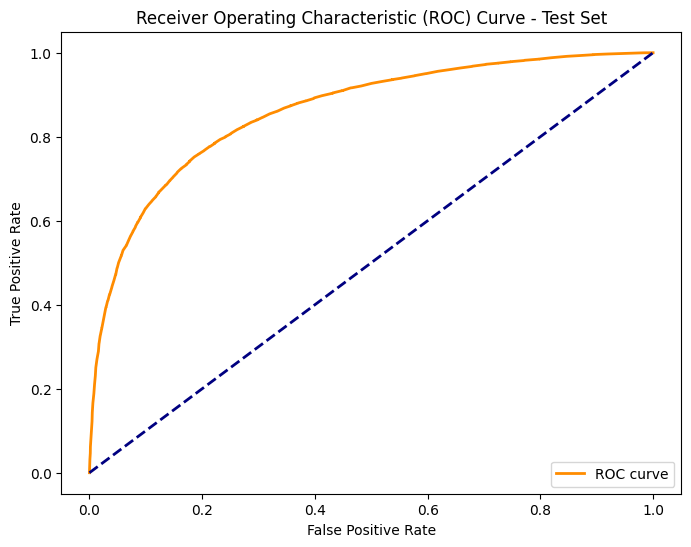

Runtime: 36.62 seconds


In [22]:
# Record start time
start_time = time.time()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Perform 5-fold cross-validation on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_test = cross_val_score(rf_model, X_test, y_test, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)

# Record time
end_time = time.time()

# Make predictions on the training set
y_pred_train = rf_model.predict(X_train)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Display cross-validation results on the test set
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy_test)


# Classification Report for the test set
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()


# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Key takeaways:
- The decision tree model shows reasonable performance on the test set, with an accuracy of 78.49%.
- Precision, recall, and F1-score are reasonably balanced for both classes, indicating a fair trade-off between precision and recall.
- The model tends to perform slightly better on the negative class (0), as indicated by higher precision, recall, and F1-score for this class.
- The confusion matrix provides a detailed breakdown of correct and incorrect predictions.
- The decision tree is better at identifying true negatives (admission) than true positives (discharge), as reflected in the higher recall for the negative class.
- The CV shows similar performance between all 5 folds. 
____

Now for us to find the best hyper parameters. 

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 72}
Training Accuracy: 0.8492680559993373

Cross-Validation Scores (5-fold - Test Set): [0.78230005 0.78485207 0.77798817 0.77420118 0.77798817]
Mean CV Accuracy (5-fold - Test Set): 0.7794659266249786
Test Accuracy: 0.7877496923222569

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81     11348
           1       0.81      0.71      0.76      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.78      0.78     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9706 1642]
 [2842 6936]]


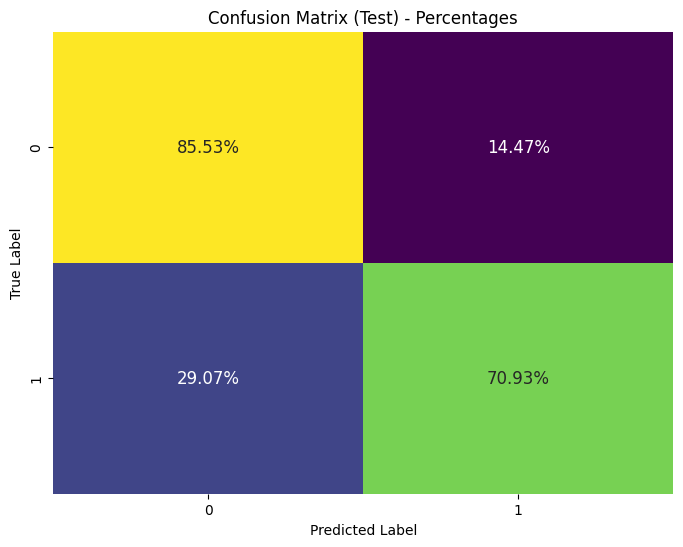

AUC-ROC Score: 0.865152494831866


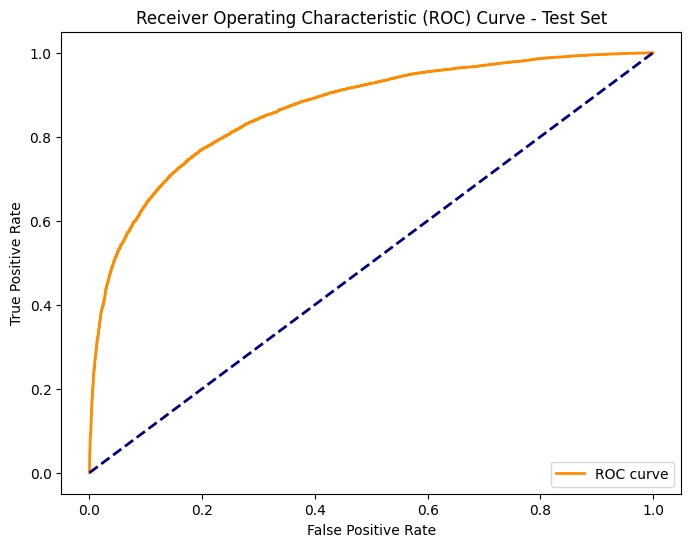

Runtime: 93.23 seconds


In [23]:
# Record start time
start_time = time.time()

# Define a smaller parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_test = cross_val_score(random_search.best_estimator_, X_test, y_test, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model on the training set
y_pred_train = best_rf_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Display cross-validation results on the test set
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy_test)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Key takeaways: 
- Test Accuracy: optimized decision tree model (0.7877) has a higher test accuracy compared to the baseline model (0.7598), indicating an improvement.
- Precision, Recall, and F1-Score: 
    - The optimized model generally shows improvements in precision, recall, and F1-score for both classes compared to the baseline model.
- CV showed relatively similar performance in all 5 folds. 

In summary, the optimized decision tree model performs better than the baseline decision tree model in terms of accuracy and most of the classification metrics. The hyperparameter tuning process has led to improved model performance. I will run another iteration based on the previously found best parameters and see if I can possibly get any improvements. 


3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/pyth

Best Parameters: {'n_estimators': 70, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini'}
Training Accuracy: 0.8191619034094271

Cross-Validation Scores (5-fold - Test Set): [0.7811169  0.78556213 0.77846154 0.76923077 0.77207101]
Mean CV Accuracy (5-fold - Test Set): 0.7772884678392705
Test Accuracy: 0.7849095900785762

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81     11348
           1       0.81      0.70      0.75      9778

    accuracy                           0.78     21126
   macro avg       0.79      0.78      0.78     21126
weighted avg       0.79      0.78      0.78     21126


Confusion Matrix (Test):
 [[9738 1610]
 [2934 6844]]


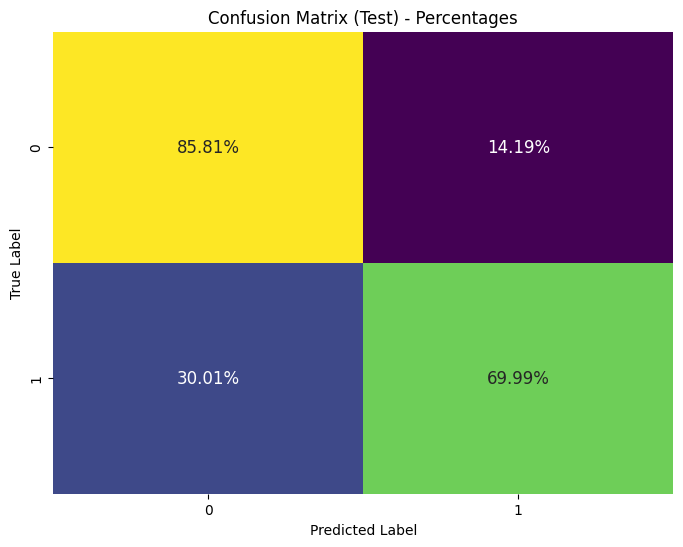

AUC-ROC Score: 0.862611150119902


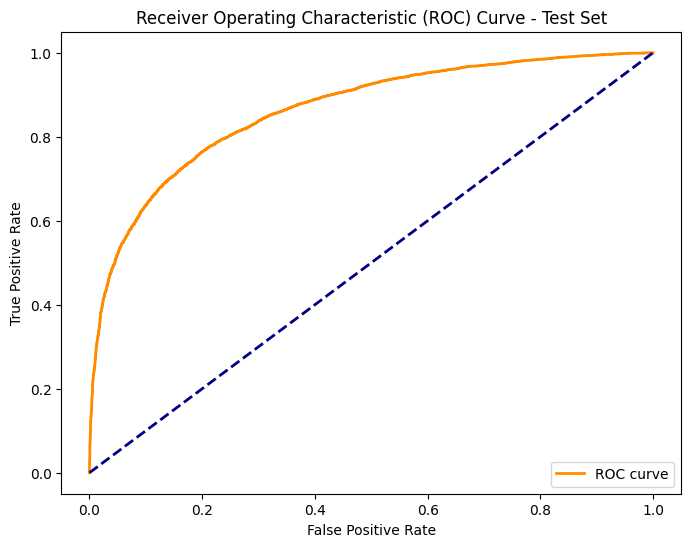

Runtime: 57.22 seconds


In [24]:
# Record start time
start_time = time.time()

# Define a smaller parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [60, 70, 80],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_test = cross_val_score(random_search.best_estimator_, X_test, y_test, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)

# Get the best model from the random search
nbest_rf_model = random_search.best_estimator_

# Predictions on the training set
y_train_pred = nbest_rf_model.predict(X_train)

# Make predictions on the test set
y_pred = nbest_rf_model.predict(X_test)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Training Accuracy:', accuracy_train)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)


# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, nbest_rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, nbest_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Training Accuracy (on Training Set):
- The model achieved a training accuracy of approximately 81.92%. This indicates that the model performed well on the data it was trained on.

Cross-Validation:
- The individual cross-validation scores range from 77.81% to 78.55%, with a mean cross-validation accuracy of approximately 77.73%. This suggests that the model is relatively consistent in its performance across different subsets of the training data.

Test Accuracy (on Test Set):
- The model achieved a test accuracy of approximately 78.49%. This is the accuracy of the model on data it has never seen before (the test set).


Test Classification Report:
Precision:  
- For class 0, precision is 0.77, and for class 1, precision is 0.81. This indicates that when the model predicts a class, it is correct about 77-81% of the time.
Recall: 
- Recall measures the ability of the model to capture all the relevant examples of a class. For class 0, recall is 0.86, and for class 1, recall is 0.70. This suggests that the model is better at capturing class 0 instances compared to class 1.
F1-score: 
- The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The weighted average F1-score is approximately 0.78.


In summary, the model demonstrates reasonable performance, but there is room for improvement, especially in correctly identifying instances of class 1 (lower recall for class 1).

Given that the previous iteration performs better, we will be using this as our final model instead. 

Top 20 Features and Their Importance Values:
Feature: dum_triage_vital__tachycardia(high)_hr, Importance Value: 0.007581832458222568
Feature: demo_age_70-79, Importance Value: 0.008117799923914832
Feature: demo_age_40-49, Importance Value: 0.008434611356626445
Feature: dum_triage_vital__normal_dbp, Importance Value: 0.009085080071540534
Feature: dum_triage_vital__pre-hypertension_sbp, Importance Value: 0.010809895893811853
Feature: pmh_htn, Importance Value: 0.011928378435784953
Feature: cc_chestpain, Importance Value: 0.013789916058288663
Feature: dum_triage_vital__hypertension(high)_sbp, Importance Value: 0.014191764826997253
Feature: dum_triage_vital__pre-hypertension_dbp, Importance Value: 0.01446269742456509
Feature: cc_alteredmentalstatus, Importance Value: 0.014863371451692269
Feature: demo_age_80-89, Importance Value: 0.015265969572799616
Feature: demo_race, Importance Value: 0.01547006773231476
Feature: pmh_chfnonhp, Importance Value: 0.01665192957964379
Feature: pmh_coronathe

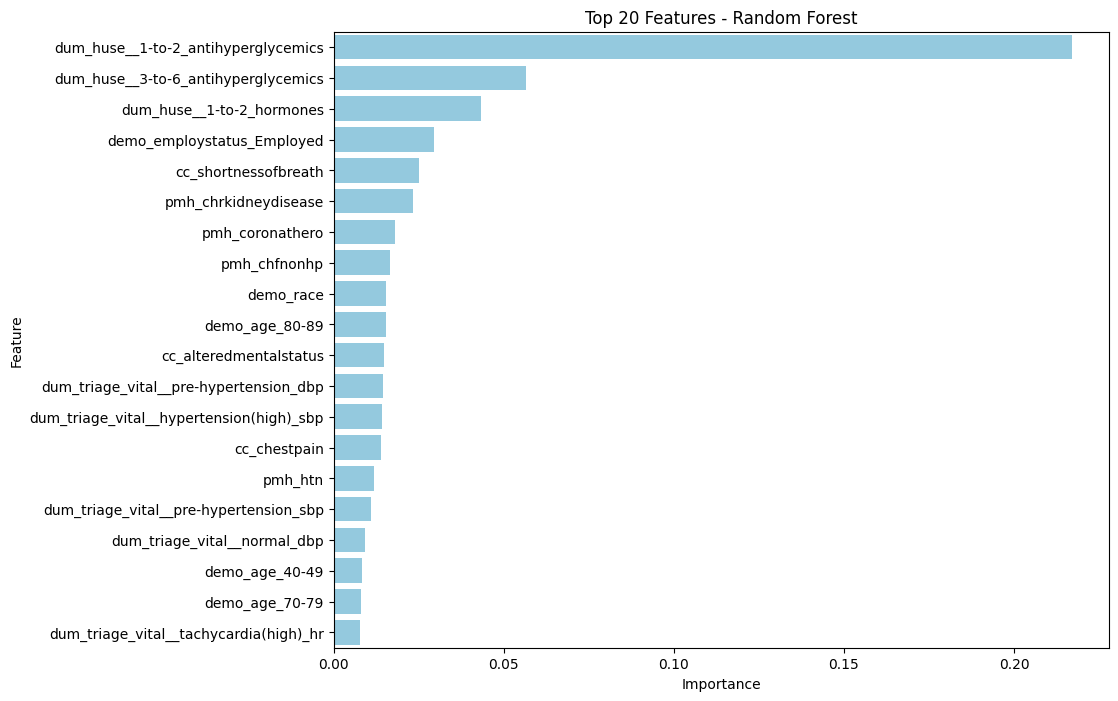

In [30]:
# Extract feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 features
top_20_features = feature_importance_df.head(20)

# Print top 20 features and their importance values
print("Top 20 Features and Their Importance Values:")
for feature, importance_value in zip(top_20_features['Feature'][::-1], top_20_features['Importance'][::-1]):
    print(f"Feature: {feature}, Importance Value: {importance_value}")

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, color='skyblue')
plt.title('Top 20 Features - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [31]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model,feature_perturbation='interventional')

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

---
#### <a id = 'xgb'></a> 1.3 xGBoost

XGBoost is another form of ensemble learning that's effective for structure data. It's a form of gradient boosting which builds a model in a stage-wise fashion where each iteration corrects the errors of the previous one. It's well suited for binary tasks and important for explainability. It will be a great addition to the other models. 

Training Accuracy: 0.8120857988165681

Cross-Validation Scores (5-fold - Test Set): [0.78838757 0.7887574  0.78609467 0.78380178 0.79607988]
Mean CV Accuracy (5-fold - Test Set): 0.7886242603550295
Validation Accuracy: 0.7879415419205964

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      9052
           1       0.81      0.71      0.76      7849

    accuracy                           0.79     16901
   macro avg       0.79      0.78      0.78     16901
weighted avg       0.79      0.79      0.79     16901



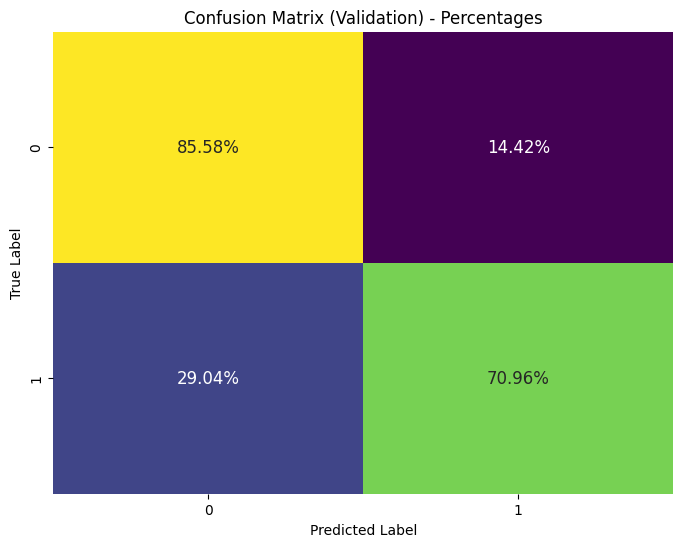

AUC-ROC Score: 0.8683223548296455


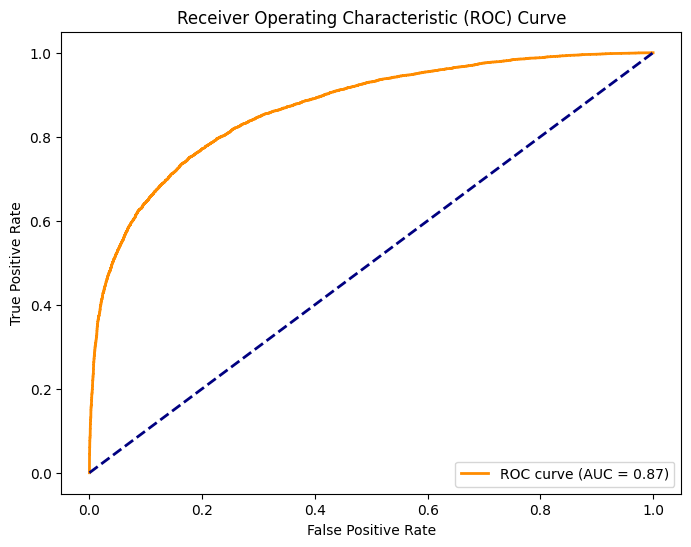

Runtime: 1.01 seconds


In [ ]:
# Record time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Predictions on the validation set
y_pred_valid = xgb_model.predict(X_valid)

# Predictions on the training set
y_pred_train = xgb_model.predict(X_train)

# 5-fold cross-validation on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_test = cross_val_score(xgb_model, X_train, y_train, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)


# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('\nClassification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]


# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Key Takeaways: 

Cross-Validation:
- The 5-fold cross-validation scores are consistent, with an average accuracy of approximately 78.93%. This suggests reasonable generalization performance.

Training Set:
- The model achieves an accuracy of 81.21% on the training set.
- Precision and recall are reasonably balanced for both classes (0 and 1).
- The F1-score for class 1 (positive class) is slightly lower, indicating some difficulty in capturing all positive instances.

 Validation Set:
-  The model performs slightly worse on the validation set with an accuracy of 78.79%.
- Precision and recall show a similar pattern to the training set, and the F1-score for class 1 is also lower.

AUC-ROC Score:
- The AUC-ROC score is 0.87, indicating good discriminatory power to distinguish between the positive and negative classes.

_____

Now that we have a good baseline model for xGBoost, let's now try to optimize it with the best hyper parameters. 

Best Parameters: {'colsample_bytree': 0.893352578649596, 'learning_rate': 0.18198808134726413, 'max_depth': 7, 'n_estimators': 122, 'subsample': 0.813010318597056}
Training Accuracy: 0.8174556213017752

Cross-Validation Scores (5-fold - Test Set): [0.78633506 0.78901627 0.78836908 0.79243713 0.7879068 ]
Mean CV Accuracy (5-fold - Test Set): 0.7888128698224851
Validation Accuracy: 0.7949704142011834
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      7410
           1       0.81      0.71      0.76      6110

    accuracy                           0.79     13520
   macro avg       0.80      0.79      0.79     13520
weighted avg       0.80      0.79      0.79     13520



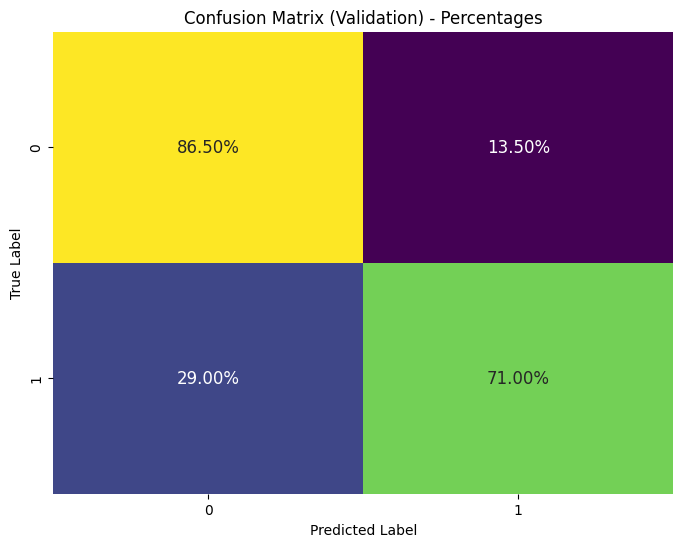

AUC-ROC Score: 0.8762551490775282


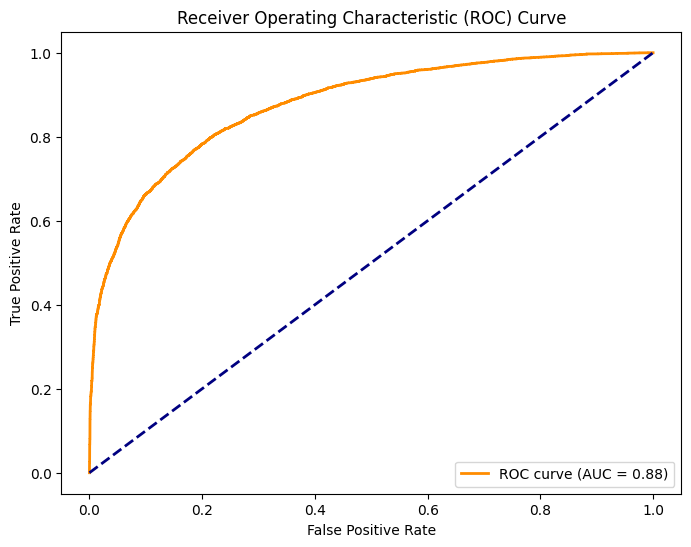

Runtime: 134.68 seconds


In [ ]:
# Record end time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 151),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
}

# Use StratifiedKFold for cross-validation with stratified sampling on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=stratified_cv_test, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Perform 5-fold cross-validation on the test set
cv_scores_test = cross_val_score(best_xgb_model, X_train, y_train, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Key takeaways:

Training Set:
- The optimized model achieves an improved accuracy of 81.83% on the training set.
- Precision and recall for both classes are well-balanced, and the F1-score for class 1 has improved compared to the base model.

Validation Set:
- The optimized model performs better on the validation set with an accuracy of 79.63%.
- Precision, recall, and F1-score for both classes have improved compared to the base model.

Cross-Validation:
- The 5-fold cross-validation scores for the optimized model are consistent, with an average accuracy of approximately 78.96%.

The optimized model shows slight improvements over the base model, especially in terms of F1-scores on the training and validation sets. The optimized model demonstrates better generalization to the validation set.

Now that we have the best parameters, let's run another iteration of random search with these values in mind and see if we can improve performance. 

Best Parameters: {'subsample': 0.9, 'n_estimators': 160, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.82}
Training Accuracy: 0.8302514792899408

Cross-Validation Scores (5-fold - Test Set): [0.78828152 0.79082399 0.78839709 0.78435225 0.78548313]
Mean CV Accuracy (5-fold - Test Set): 0.7874675946637072
Validation Accuracy: 0.7929918639053254
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      5926
           1       0.80      0.73      0.76      4890

    accuracy                           0.79     10816
   macro avg       0.79      0.79      0.79     10816
weighted avg       0.79      0.79      0.79     10816



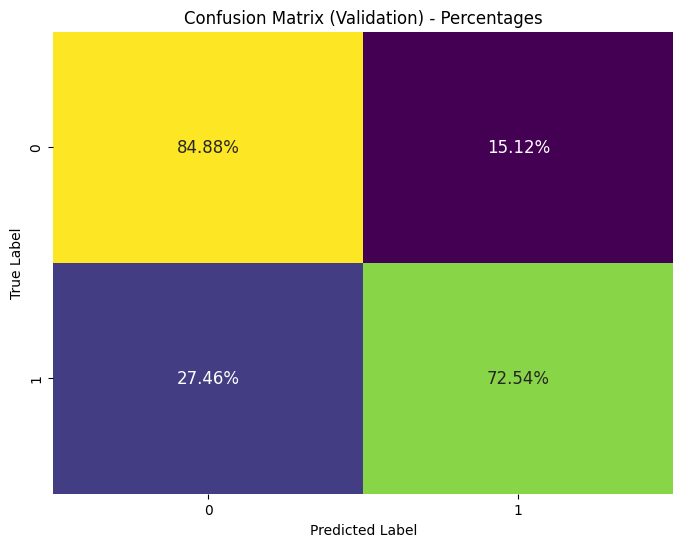

AUC-ROC Score: 0.9018702201038439


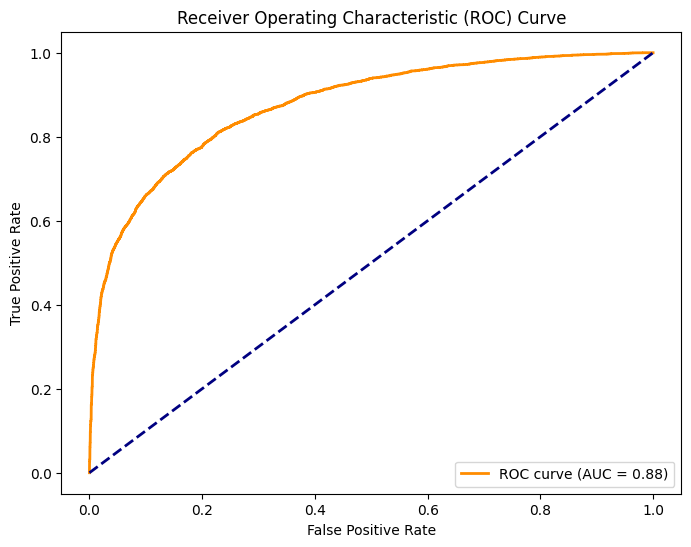

Runtime: 196.59 seconds


In [ ]:
# Record end time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
nxgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [5, 6, 7, 8, 9],
    'n_estimators': [130, 140, 150, 160, 170],
    'subsample': [0.9, 0.92, 0.94, 0.96, 0.98, 1.0],
    'colsample_bytree': [0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
}

# Use StratifiedKFold for cross-validation with stratified sampling on the test set
stratified_cv_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(nxgb_model, param_distributions=param_dist, n_iter=50, cv=stratified_cv_test, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Get the best model from the random search
nbest_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = nbest_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = nbest_xgb_model.predict(X_train)

# Perform 5-fold cross-validation on the test set
cv_scores_test = cross_val_score(nbest_xgb_model, X_train, y_train, cv=stratified_cv_test, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold - Test Set):', cv_scores_test)
print('Mean CV Accuracy (5-fold - Test Set):', mean_cv_accuracy_test)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, nbest_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Looking at performance, it appears as though the second iteration performs worse. so I will now use the first iteration as the best model instead. 

Top 20 Features and Importances:
dum_huse__3-to-6_antihyperglycemics: 0.06431729346513748
dum_huse__1-to-2_antihyperglycemics: 0.06159216910600662
dum_huse__1-to-2_hormones: 0.03034462407231331
cc_alteredmentalstatus: 0.02224895916879177
cc_shortnessofbreath: 0.014335663989186287
cc_strokealert: 0.01218316052109003
cc_motorvehiclecrash: 0.011024207808077335
cc_abnormallab: 0.010265970602631569
demo_employstatus_Employed: 0.009875118732452393
dum_triage_vital__hypotension(low)_sbp: 0.00978198554366827
cc_neurologicproblem: 0.009602433070540428
cc_chestpain: 0.009489908814430237
cc_fever-9weeksto74years: 0.00920190755277872
cc_weakness: 0.009030874818563461
demo_age_90-99: 0.008678627200424671
cc_emesis: 0.00830296240746975
cc_dyspnea: 0.008238112553954124
cc_fatigue: 0.008154458366334438
cc_rash: 0.008041814900934696
cc_gibleeding: 0.008027618750929832


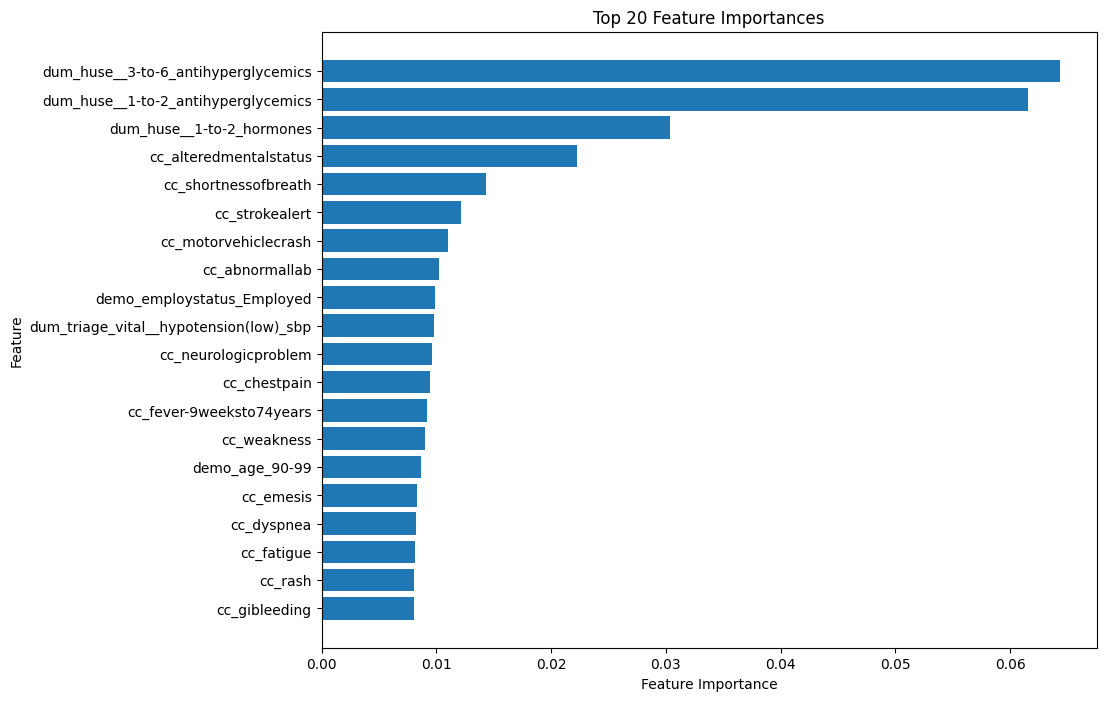

In [ ]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get the indices of the top 20 features
top20_indices = np.argsort(feature_importances)[-20:]

# Get the names of the top 20 features
top20_features = X_train.columns[top20_indices]

# Print top 20 features and their importances
print("Top 20 Features and Importances:")
for feature, importance in zip(top20_features[::-1], feature_importances[top20_indices][::-1]):
    print(f'{feature}: {importance}')

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(top20_features)), feature_importances[top20_indices], align='center')
plt.yticks(range(len(top20_features)), top20_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

[00:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


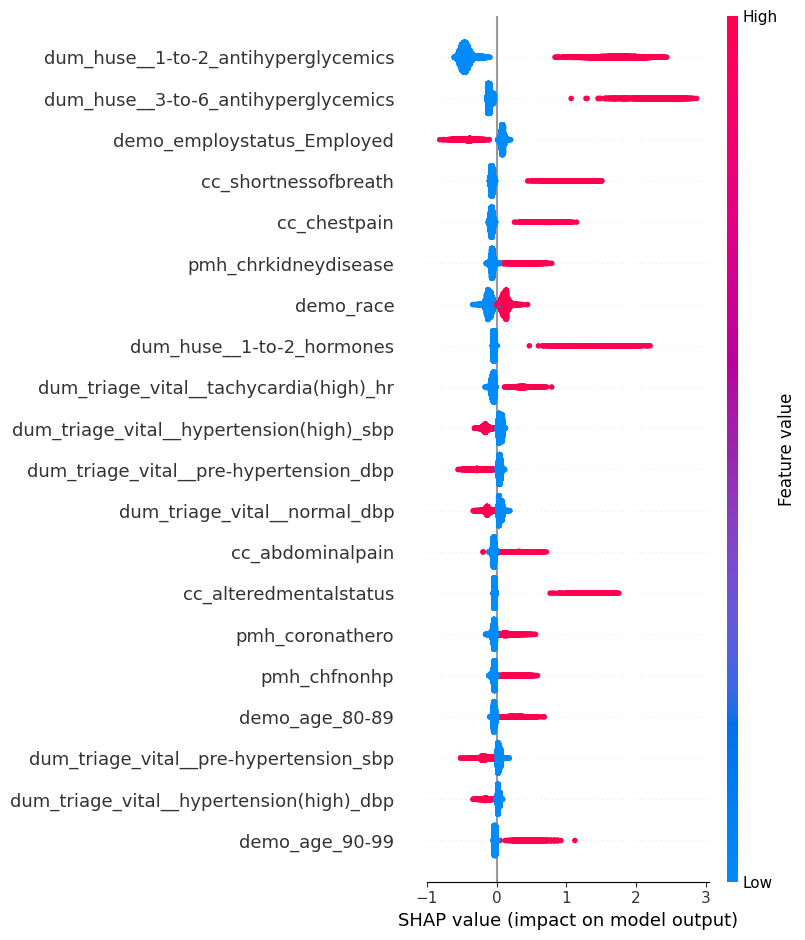

In [ ]:
# Create an explainer
explainer = shap.TreeExplainer(best_xgb_model,feature_perturbation='interventional')

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
# Calculate the average absolute SHAP values for each feature
avg_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 10 features
top10_feature_indices = np.argsort(avg_abs_shap_values)[-10:]

# Extract the corresponding feature names
top10_feature_names = X_test.columns[top10_feature_indices]

# Extract the average SHAP values for the top 10 features
top10_avg_shap_values = avg_abs_shap_values[top10_feature_indices]

# Print the top 10 features and their average SHAP values
for feature, avg_shap_value in zip(top10_feature_names, top10_avg_shap_values):
    print(f"Feature: {feature}, Average SHAP Value: {avg_shap_value}")


---
### <a id = 'conc'></a> Conclusion

Now that we have ran our advanced models and optimized them. It's clear that of the advanced models, xGBoost performed the best. It's performance is slightly better than the optimized logistic regression. I will now export these models so that it can later be used on unseen data.

In [ ]:
# Save the model
dump(best_rf_model, 'KLO_BStn_RF.joblib')

['KLO_BStn_RF.joblib']

Now for the xGBoost

In [ ]:
# Save the XGBoost model to a JSON file
model_json = best_xgb_model.get_booster().get_dump(dump_format='json')
with open('KLO_BStn_xGB.json', 'w') as json_file:
    json.dump(model_json, json_file)


Now that all of the modelling has been completed, we can now look into how we could build a discrimination test and see if implementing this test will affect the performance of these models. 

____